In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
import torch as pt
import cartpole_tools as cp
%matplotlib inline

env = cp.Pendulum()

Neural networks are parameterized nonlinear functions that are particularly useful for learning applications.

Below, we will examine functions of the form
$$
y = f(x)
$$
where $x\in\mathbb{R}^{n_x}$ and $y\in\mathbb{R}^{n_y}$ are *row vectors*. (The row vector convention is for consistency with PyTorch, which will be described layer)

Neural networks can be used to approximate the function, $f$.
The simplest neural network has the form:
$$
\hat f(x,\theta) = \sigma(x W_{in} + b_{in}) W_{out} + b_{out} 
$$
where $\theta = (W_{in},b_{in},W_{out},b_{out})$ are the *parameters* and $\sigma$ is a nonlinear function that is applied entrywise. Here $W_{in}$ is an $n_x \times n_h$ matrix and $b_{in}$ is a $1\times n_h$ row vector. So, for consistency with the output dimension, we  must have that $W_{out}$ is a $n_h\times n_y$ matrix and $b_{out}$ is a $1\times n_y$ row vector.

Neural networks can take more complex forms such as:
$$
\hat f(x,\theta) = \sigma(\sigma(\sigma(x W_{in} + b_{in})W_{h_1}+b_{h_1})W_{h_2}+b_{h_2})) W_{out} + b_{out} 
$$
This network has depth 4, as we pass the input through three hidden layers before finally reaching the linear output layer. In this case, $\theta = (W_{in},b_{in},W_{h_1},b_{h_1},W_{h_2},b_{h_2},W_{out},b_{out})$.

More sophisticated and specialized architectures are utilized for applications such as image processing and text analysis.

The goal in neural networks is to optimize the parameters so that $\hat f(x,\theta)\approx f(x)$. The standard approach is to collect samples $(x_1,y_1),\ldots,(x_N,y_N)$ such that  $y_i=f(x_i)$ and then optimize mean-squared error loss:
\begin{equation*}
Loss(\theta) = \frac{1}{N}\sum_{i=1}^N \|y_i - \hat f(x_i,\theta)\|^2.
\end{equation*}

In many cases, the number of samples, $N$ is massive, and so just calculating the exact loss is impractical. In this setting, it is typical to subsample the data and use *minibatches*, $B\subset \{1,\ldots,N\}$:
\begin{equation*}
Loss(\theta,B) = \frac{1}{|B|}\sum_{x_i\in B}^N \|y_i - \hat f(x_i,\theta)\|^2.
\end{equation*}

In PyTorch, minibatches for $nX$-dimensional inputs are given as matrices of dimension $|B|\times nX$.


Then the parameters are trained using stochastic gradient descent. Here we initialize $\theta_0$, typically at random, and then using a sequence of minibatches $B_t\subset\{1,\ldots,N\}$, we set:
$$
\theta_{t+1} = \theta_t - \alpha \nabla_\theta Loss(\theta,B_t).
$$
Here  $\alpha >0$ is called the learning rate.

Many variations and improvements on stochastic gradient descent exist, some of which work much better and more robustly. In the code below, we will use a method known as *Adam*. 

The code below implements a neural network for identifying a nonlinear function.

In [2]:
class RegressionNetwork(pt.nn.Module):
    """
    This is a basic neural network for fitting functions of the form
    y = f(x)
    via nonlinear least squares
    
    nX - dimension of input
    nY - dimension of output
    nH - number of units in the hidden layers
    nL - number of total layers. (must be at least two)
    learningRate - gradient descent step size
    nonlinearity - a nonlinear function used between layers
    """
    def __init__(self,nX,nY,nH,nL=2,learningRate=1e-2,nonlinearity=pt.tanh):
        """
        The __init__ function sets up the network
        """
        super(RegressionNetwork,self).__init__()
        # Define the linear layers. These hold the parameters.
        self.inputLin = pt.nn.Linear(nX,nH)
        self.outputLin = pt.nn.Linear(nH,nY)
        self.hiddenLin = [pt.nn.Linear(nH,nH) for _ in range(nL-2)]
        
        # The nonlinear function
        self.nl = nonlinearity
        
        
        # Optimization Method - Using Adam, which is an adaptive stochastic
        # gradient method
        self.optimizer = pt.optim.Adam(self.parameters(),lr=learningRate)
        self.criterion = pt.nn.MSELoss()
        
    def forward(self,x_minibatch):
        """
        The forward function is the main action of the neural net
        
        y_minibatch = net.forward(x_minibatch)
        
        This function implements our approximationn to the function f
        
        PyTorch neural networks assume that inputs are minibatches of size:
        nB x nX
        
        where
        nB is the number of samples in the minibatch
        nX is the dimension of the input
        """
        
        h = self.nl(self.inputLin(x_minibatch))
        for layer in self.hiddenLin:
            h = self.nl(layer(h))
        
        y_minibatch = self.outputLin(h)
        return y_minibatch
    
    
    def optimizer_step(self,x_minibatch,y_minibatch):
        
        # Calculate our prediction
        y_pred = self.forward(x_minibatch)
        # Calculate the loss
        loss = self.criterion(y_pred,y_minibatch)
        
        # Clear the gradient buffers
        self.optimizer.zero_grad()
        # Compute the gradient
        loss.backward()
        # Update the parameters
        self.optimizer.step()
        
        return loss

Now our first coding will be on approximating the function 

$$
c = p^2 + 1-\cos(\theta)
$$

This is the cost function for the cart-pole problem studied in homework 4.

For visualization purposes, we will first just fit the function $c=p^2$. 

If you play around with various settings such as, minibatch size, number of minibatches, learning rate, dimension of the hidden layers (nH), you will get different results. (You can make it essentially exact, if you train it long enough.)

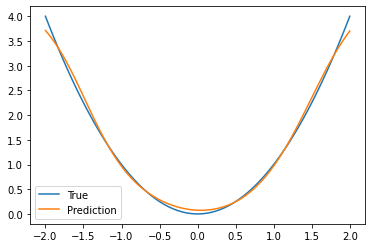

In [3]:
# Let's test it on a one-dimensional function

# Our system only examines p in [-2,2]
p_plot = pt.linspace(env.LB_X[0],env.UB_X[0],100)

quad_plot = p_plot**2
plt.plot(p_plot,quad_plot,label='True')

# Define the neural network
nH = 10
lr = 1e-2
nP = 1
nC = 1
quad_id = RegressionNetwork(nP,nC,nH,learningRate=lr)

# Train it
minibatchSize = 10
numMinibatches = 1000

# An object to sample uniformly on the desired domain
p_unif = pt.distributions.Uniform(pt.tensor([env.LB_X[0]],dtype=pt.float),
                                  pt.tensor([env.UB_X[0]],dtype=pt.float))

for mb in range(numMinibatches):
    p_mb = p_unif.rsample((minibatchSize,))
    y_mb = p_mb**2
    loss = quad_id.optimizer_step(p_mb,y_mb)
    
    
# Check our prediction
quad_pred = quad_id(p_plot.view((-1,1)))
plt.plot(p_plot,quad_pred.detach().numpy(),label='Prediction')
    
plt.legend()

# Coding Question 1

Repeat the process we had for $c=p^2$, but now fit the function
$$
c = 1-\cos(\theta)
$$
for $\theta\in [-20,20]$.

Hints: It is possible to get a very close fit on this, but in comparison to the quadratic you will likely need:
- More hidden units. (i.e. higher nH)
- Longer training. (i.e. more minibatches)


In [ ]:
# Put your code here

# An environment for the pendulum swing-up problem.

Here we describe an environment that is similar to OpenAI gym for the pendulum on a cart swing-up problem. (I am not sure if it is fully compatible, but it is similar.)




step 1 cost 0.9880702016571048
step 2 cost 1.2208541285452017
step 3 cost 1.5291757079676995
step 4 cost 1.838578238071283
step 5 cost 2.009193983047333
step 6 cost 1.9295841968094423
step 7 cost 1.7060047396142206
step 8 cost 1.4593081131660768
step 9 cost 1.262642320946111
step 10 cost 1.1517556408317347
step 11 cost 1.1391668274423625
step 12 cost 1.2227287302095267
step 13 cost 1.3961713153380162
step 14 cost 1.6361653905609415
step 15 cost 1.881990445901753
step 16 cost 2.0329095290599675
step 17 cost 2.03476072246363
step 18 cost 1.9355567173586319
step 19 cost 1.7841837456140528
step 20 cost 1.6473678830930223
step 21 cost 1.5528127227434538
step 22 cost 1.5037246609025328
step 23 cost 1.5124879619075642
step 24 cost 1.5953175903938395
step 25 cost 1.7372143728031602
step 26 cost 1.9039039125418977
step 27 cost 2.0369549474799857
step 28 cost 2.055918734792809
step 29 cost 1.9664971429402514
step 30 cost 1.8134901738078562
step 31 cost 1.6424066205531351
step 32 cost 1.501156339

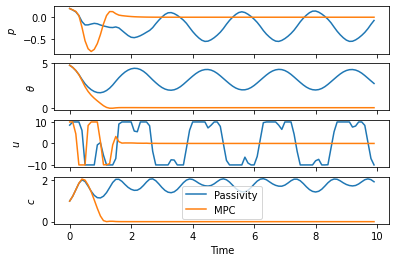

In [4]:
env = cp.Pendulum()
# Passivity-based swinging controller 
agentPassivity = cp.PassivitySwingUp()
# MPC with 15 step horizon
agentMPC = cp.MPCAgent(15)
Agents = [(agentPassivity,'Passivity'),(agentMPC,'MPC')]

x0 = env.reset()
NumSteps = 100

fig,ax = plt.subplots(4,1,sharex=True)

for agent,label in Agents:
    X = []
    X_next = []
    U = []
    C = []
    x = np.copy(x0)
    # Forces both simulations to start at the same initial condition
    env.x = np.copy(x)
    for step in range(NumSteps):
    
        u = agent.action(x)
        x_next,c,done,info = env.step(u)
        X.append(x)
        U.append(u)
        X_next.append(x_next)
        C.append(c)
    
        print('step',step+1,'cost',c)
        if done:
            break
        else:
            x = np.copy(x_next)
        
    X = np.array(X)
    U = np.array(U)
    C = np.array(C)
    print(label,np.mean(C))

    Time = env.dt *np.arange( len(X))

    ax[0].plot(Time,X[:,0])
    
    ax[1].plot(Time,X[:,1])
    ax[2].plot(Time,U)
    ax[3].plot(Time,C,label=label)
    
ax[0].set_ylabel(r'$p$')
ax[1].set_ylabel(r'$\theta$')
ax[2].set_ylabel(r'$u$')
ax[3].set_ylabel(r'$c$')
ax[3].set_xlabel('Time')
ax[3].legend()
    


# Policy Evaluation as a Regression Problem

Recall that for a deterministic system, $x_{t+1}=f(x_t,u_t)$, if $u_t = \pi(x_t)$ is defined by the deterministic policy, $\pi$, and and $x_0=x$, then the corresponding value function is given by:
$$
V_{\pi}(x) = \sum_{t=0}^{\infty}\gamma^t c(x_t,u_t)
$$

Here we will assume that $\gamma \in [0,1)$.

We saw in class that $V_{\pi}$ could be estimated by the Bellman equation. In the next few questions, we derive an alternative method.

# Theory Question 1

Assume that $|c(x,u)|\le c_{\max}$ for all feasible $x,u$. (In this particular case, $c_\max=6$.) Given an error tolerance, $\epsilon$, find a horizon-length $\tau$ such that
$$
\left|
\sum_{t=0}^\tau \gamma^t c(x_t,u_t) -V_{\pi}(x)
\right| \le \epsilon
$$
for all $x$.

# Coding Question 2

Here we will do policy evaluation for the passivity-based control method (`agentPassivity`) for $\gamma = 0.9$. with error tolerance $0.1$ and $c_\max=6$.

The method works as follows:

* Generate a minibatch of samples. Each sample is generated by the following process:
    * Generate a random feasible $x$ initial condition the function `env.observation_space.sample()`
    * Run a simulation of length $\tau$ (found earlier) and record the cost $v=\sum_{t=0}^\tau c(x_t,u_t)$.
    * The sample consists of input $x\in\mathbb{R}^4$ and cost $v$
* Train as in the previous problem.

Print the mean-squared error losses as you go. (If you use a lot of minibatches, only print every so often, like every 1000, for example.)

Some hints and caveats:
* This is an open-ended question. Getting the right network parameters for this problem is fairly difficult. Make it fit as well as you can, but don't spend your life changing parameters. (Even getting MSE in the 100s can be tricky.) 
* Make sure that each simulation starts from the randomly generated $x$. (See the coding example above)
* Be mindful to cast things into PyTorch format. (For consistency with the default PyTorch data types, you'll probably need to use commands like `X_pt = pt.tensor(X,dtype=pt.float)`)
* If the simulation ever exits the feasible region (which is a box),  it just stays fixed at the infeasible point and incurs the maximum possible cost. (This penalizes the trajectory for leaving the feasible region.) Do not reset your trajectories if they leave the feasible region. Just simulate till $\tau$ is reached.

In [272]:
# Put your code here

# Coding Question 3

Now instead of the pure regression approach, utilize the Bellman equation:
$$
V_{\pi}(x) = c(x,\pi(x)) + \gamma V_{\pi}(f(x,\pi(x))
$$

So, if we have a neural network approximation, $\hat V(x,\theta)$, we can train by applying stochastic gradient descent to minibatches with losses of the form:
$$
Loss(\theta,B) = \frac{1}{|B|}\sum_{x_i\in B} |c(x_i,\pi(x_i))+\gamma V(f(x_i,\pi(x_i)),\theta)-V(x_i,\theta)|^2
$$

The proceedure for generating a sample is:
* Sample a feasible state, $x$, again using `env.observation_space.sample()`
* Compute the corresponding input, $u$.
* Simulate a single step. 

So, we can see that the basic optimization step of the original neural network will need to be modified since it is no longer just the least squares cost. 

As before, print out your losses as you go, so I can check it. 

Hints and Caveats:
* The numbers are much smaller for this than for the pure regression approach. So, it is a bit easier to get convergence. Mean-square errors less than 1 can be achieved, but it might take some hacking. Again, don't spend TONS of time hacking this.
* Since samples are easier to generate, you can probably use larger minibatch sizes and more total iterations.
* Getting low MSE could take a long run. Got get some food or take a walk. 

In [ ]:
# Put your code  here